In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [2]:
# Load the CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

Files already downloaded and verified


In [3]:
# Define the classes ('airplane' and 'automobile' in this case)
classes_to_keep = ['airplane', 'automobile']

# Filter out the images corresponding to the specified classes
filtered_dataset = []

for img, label in cifar_dataset:
    class_name = cifar_dataset.classes[label]
    if class_name in classes_to_keep:
        filtered_dataset.append((img, label))

# Split the filtered dataset into training and testing sets
train_size = int(0.8 * len(filtered_dataset))
test_size = len(filtered_dataset) - train_size

train_dataset, test_dataset = random_split(filtered_dataset, [train_size, test_size])

# Create DataLoader instances for training and testing
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [4]:


# Define the architecture for the Speaker and Listener agents
class Speaker(nn.Module):
    def __init__(self, input_size, message_size):
        super(Speaker, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # Input size is the flattened image size
        self.fc2 = nn.Linear(128, message_size)

    def forward(self, x):
        x = torch.flatten(x, 1)  # Flatten the input image
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

class Listener(nn.Module):
    def __init__(self, message_size, num_classes):
        super(Listener, self).__init__()
        self.fc1 = nn.Linear(message_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the models
input_size = 3 * 32 * 32  # Flattened image size
message_size = 5  # Message size
num_classes = 2  # Number of classes ('airplane' and 'automobile')

speaker = Speaker(input_size, message_size)
listener = Listener(message_size, num_classes)

# Print model architectures
print("Speaker architecture:")
print(speaker)
print("\nListener architecture:")
print(listener)


Speaker architecture:
Speaker(
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)

Listener architecture:
Listener(
  (fc1): Linear(in_features=5, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


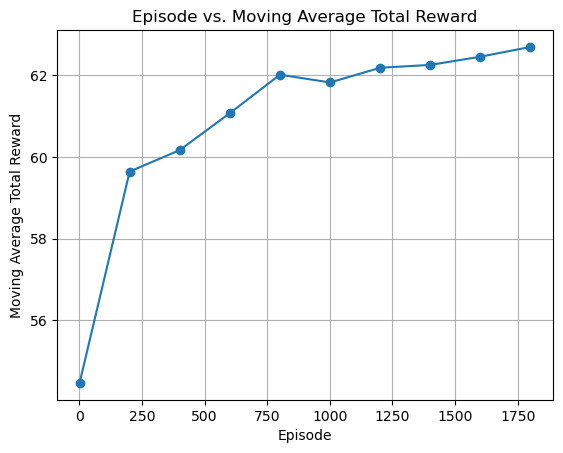

In [5]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Define hyperparameters
learning_rate = 0.001
num_episodes = 2000
max_steps_per_episode = 100

# Define the reward function
def compute_reward(predicted_class, true_class):
    # The reward is +1 for a correct classification, 0 otherwise
    return 1 if predicted_class == true_class else 0

# Define optimizer and loss function for the Listener
optimizer_listener = optim.Adam(listener.parameters(), lr=learning_rate)
criterion_listener = nn.CrossEntropyLoss()

# Lists to store episode and total reward data for plotting
episode_list = []
total_reward_list = []

# Moving average window size (number of points to consider)
moving_average_window = 200  # Calculate moving average every 200 episodes

# Training loop
for episode in range(num_episodes):
    total_reward = 0
    
    for step in range(max_steps_per_episode):
        # Sample a random image from the training dataset
        sample_idx = np.random.randint(len(train_dataset))
        image, true_class = train_dataset[sample_idx]
        
        # Speaker produces a message
        message = speaker(image.view(1, -1))  # Flatten and pass as a batch of size 1
        
        # Listener predicts the class from the message
        predicted_scores = listener(message)
        predicted_class = torch.argmax(predicted_scores)
        
        # Compute the reward based on Listener's prediction
        reward = compute_reward(predicted_class, true_class)
        
        # Update the total reward
        total_reward += reward
        
        # Calculate the loss for the Listener
        loss_listener = criterion_listener(predicted_scores.view(1, -1), torch.tensor([true_class]))
        
        # Update the Listener's model
        optimizer_listener.zero_grad()
        loss_listener.backward()
        optimizer_listener.step()
        
    # Append episode and total reward data to lists
    episode_list.append(episode + 1)
    total_reward_list.append(total_reward)
    
    # Calculate moving average every 200 episodes and store it
    if (episode + 1) % moving_average_window == 0:
        moving_average = np.mean(total_reward_list[-moving_average_window:])
        total_reward_list[-moving_average_window:] = [moving_average] * moving_average_window

# Plot only 10 points with a line connecting them
plt.plot(episode_list[::moving_average_window], total_reward_list[::moving_average_window], marker='o', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Moving Average Total Reward")
plt.title("Episode vs. Moving Average Total Reward")
plt.grid(True)
plt.show()
